# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%run ../../setup_project.py
%run ../../generic_plot_functions.py

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Functions

In [3]:
import collections

def nested_dict():
    return collections.defaultdict(nested_dict)

def load_spikeA_one_session(ses,pose_file_extension = ".pose.npy"):

    ses.load_parameters_from_files() 
    ap = Animal_pose(ses)
    ap.pose_file_extension = pose_file_extension # This means that the ap will always load from this extension
    ap.load_pose_from_file()
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(ses)
    cg = Cell_group(stl,ap)
    # we want to keep ap and cg after the function ends, one way is to store it in our sSes
    ses.ap = ap
    ses.cg = cg
    
def prepare_ses_sSes(sessionName):
    sSes = [sSes for sSes in sSessions if sSes.name == sessionName][0]
    ses = myProject.getSession(sessionName)

    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
        
    load_spikeA_one_session(sSes)

    getSearchHomingIntervals(ses,sSes)
    
    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    
    return ses, sSes

# Simulate a grid cell

In [4]:
testSession = 'jp3129-04062022-0108'

In [5]:
from spikeA.Neuron import Simulated_grid_cell

In [6]:
# load grid cell parameters
ses, sSes = prepare_ses_sSes(testSession)

In [7]:
fn = sSes.fileBase+".grid_cell_parameters.pkl"
with open(fn, 'rb') as fp: 
    params = pickle.load(fp)

In [8]:
paramsNeeded = params[4]

In [9]:
paramsNeeded

{'name': '389',
 'grid_param_initial': {'period': array([25.64550687, 25.64550687, 25.64550687]),
  'offset': array([-44,  -6]),
  'peak_rate': 25,
  'orientation': array([1.03549702, 2.08854484, 3.12404186])},
 'grid_param_model_rigid': {'period': array([25.954012, 25.954012, 25.954012], dtype=float32),
  'offset': array([-38.745296 ,   0.6185915], dtype=float32),
  'peak_rate': array([17.531809], dtype=float32),
  'orientation': array([1.13672638, 2.18392393, 3.23112148])},
 'loss_rigid': array(128.72095, dtype=float32),
 'r_rigid': 0.607279962750901,
 'grid_param_model_flexible': {'period': array([28.524876, 23.573883, 24.056034], dtype=float32),
  'offset': array([-37.234783 ,  -1.4142337], dtype=float32),
  'peak_rate': array([19.710678], dtype=float32),
  'orientation': array([1.1238792, 2.216137 , 3.0987103], dtype=float32)},
 'loss_flexible': array(119.82578, dtype=float32),
 'r_flexible': 0.7496378983277584}

In [10]:
# load grid cell parameters
ses, sSes = prepare_ses_sSes(testSession)

interName = 'all_dark'
sSes.ap.set_intervals(ses.intervalDict[interName])
animalPose = sSes.ap.pose_ori


In [11]:
animalPose.shape

(590592, 8)

In [12]:
testSim = Simulated_grid_cell(name=f"test_389", 
                                   offset=paramsNeeded['grid_param_model_flexible']["offset"],
                                   orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                   period=paramsNeeded['grid_param_model_flexible']["period"], 
                                   peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

In [13]:
testSim

In [14]:
xy_range=np.array([[-50,-50],[50,50]])
testSim.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)

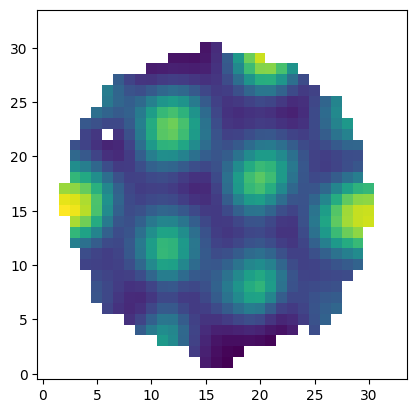

In [15]:
plt.imshow(testSim.spatial_properties.firing_rate_map.T, origin='lower',cmap='viridis')

# Anchoring the grid cells everytime the animal is near the lever in darkness.

In [16]:
def anchorPositionByShifting(sessionName,interName="all_dark",maxDistance=18):
    
    ses, sSes = prepare_ses_sSes(sessionName)
    
    
    leverX,leverY,leverOri = getLeverPosition(ses)
    mouseX = sSes.ap.pose_ori[:,1]-leverX
    mouseY = sSes.ap.pose_ori[:,2]-leverY

    D = np.sqrt(mouseX**2+mouseY**2)
    sSes.ap.pose_ori[:,1][D>maxDistance]= np.nan
    sSes.ap.pose_ori[:,2][D>maxDistance]= np.nan
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    #print(ses.intervalDict[interName])
    print(sSes.ap.pose_ori.shape)
    
    return sSes

In [17]:
sSes = anchorPositionByShifting(testSession)

(590592, 8)


In [18]:
testSim = Simulated_grid_cell(name=f"test_389", 
                                   offset=paramsNeeded['grid_param_model_flexible']["offset"],
                                   orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                   period=paramsNeeded['grid_param_model_flexible']["period"], 
                                   peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

In [19]:
xy_range=np.array([[-50,-50],[50,50]])
testSim.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)

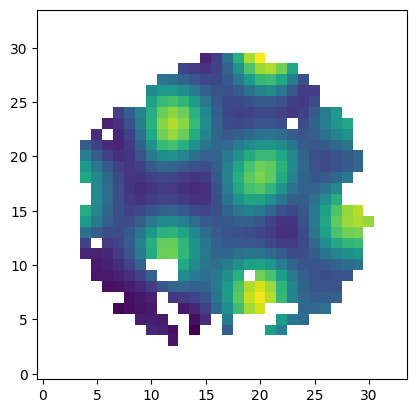

In [20]:
# NOTE This is the map with no reanchoring
plt.imshow(testSim.spatial_properties.firing_rate_map.T, origin='lower',cmap='viridis')

# Test reanchoring position

In [21]:
sSes = anchorPositionByShifting(testSession,interName='all_dark')

(590592, 8)


In [22]:
ses.intervalDict['all_dark']

array([[2940.12, 2961.66],
       [3127.24, 3134.94],
       [3380.36, 3391.64],
       [3629.64, 3639.44],
       [3690.48, 3710.  ],
       [3847.62, 3866.04],
       [4022.82, 4050.04],
       [4250.32, 4263.06],
       [4324.64, 4344.84],
       [4484.6 , 4513.86],
       [4576.82, 4586.88],
       [4696.02, 4709.62],
       [4805.78, 4843.94],
       [4955.6 , 4971.3 ],
       [5191.78, 5208.5 ],
       [5355.58, 5362.14],
       [5453.92, 5466.48],
       [5533.42, 5546.08],
       [5681.28, 5698.08],
       [5753.3 , 5764.3 ],
       [5827.58, 5834.82],
       [6001.04, 6012.74],
       [6068.62, 6106.78],
       [6237.86, 6249.3 ],
       [6364.3 , 6381.52],
       [6469.  , 6502.04],
       [6581.  , 6594.8 ],
       [6667.92, 6676.02],
       [6812.56, 6822.54],
       [6981.92, 6997.94],
       [7042.54, 7060.48],
       [7167.72, 7184.92],
       [7282.3 , 7288.  ],
       [7356.1 , 7367.3 ],
       [7411.3 , 7417.  ],
       [7475.08, 7479.74],
       [7571.36, 7583.98],
 

In [23]:
sSes.ap.pose_ori.shape

(590592, 8)

In [24]:
ses, sSes = prepare_ses_sSes(testSession)

interName = 'all_dark'
# Assuming sSes.ap.pose_ori is a NumPy array with shape (590592, 8)
pose_ori = sSes.ap.pose_ori.copy()

# Retrieve the interval array from the dictionary
interval = ses.intervalDict[interName]  # Shape: (14, 2)

# Step 2: Select half of the intervals
n_half = len(interval) // 2
selected_intervals = interval[:n_half]
print(selected_intervals.shape)

# Step 3: Create a mask for positions within the selected intervals
epsilon = 1e-5
mask = np.zeros(pose_ori.shape[0], dtype=bool)
for start, end in selected_intervals:
    mask |= (pose_ori[:, 0] >= start - epsilon) & (pose_ori[:, 0] <= end + epsilon)

# Step 4: Add 20 to the x (column 1) and y (column 2) coordinates for masked positions
# Ensure that we don't modify NaN values
pose_ori[mask, 1] = np.where(np.isnan(pose_ori[mask, 1]), np.nan, pose_ori[mask, 1] + 20)
pose_ori[mask, 2] = np.where(np.isnan(pose_ori[mask, 2]), np.nan, pose_ori[mask, 2] + 20)

# Step 5: Assign the modified array back to sSes.ap.pose_ori
sSes.ap.pose_ori = pose_ori

sSes.ap.set_intervals(interval)



(28, 2)


In [25]:
paramsNeeded

{'name': '389',
 'grid_param_initial': {'period': array([25.64550687, 25.64550687, 25.64550687]),
  'offset': array([-44,  -6]),
  'peak_rate': 25,
  'orientation': array([1.03549702, 2.08854484, 3.12404186])},
 'grid_param_model_rigid': {'period': array([25.954012, 25.954012, 25.954012], dtype=float32),
  'offset': array([-38.745296 ,   0.6185915], dtype=float32),
  'peak_rate': array([17.531809], dtype=float32),
  'orientation': array([1.13672638, 2.18392393, 3.23112148])},
 'loss_rigid': array(128.72095, dtype=float32),
 'r_rigid': 0.607279962750901,
 'grid_param_model_flexible': {'period': array([28.524876, 23.573883, 24.056034], dtype=float32),
  'offset': array([-37.234783 ,  -1.4142337], dtype=float32),
  'peak_rate': array([19.710678], dtype=float32),
  'orientation': array([1.1238792, 2.216137 , 3.0987103], dtype=float32)},
 'loss_flexible': array(119.82578, dtype=float32),
 'r_flexible': 0.7496378983277584}

In [26]:
testSim = Simulated_grid_cell(name=f"test_389", 
                                   offset=paramsNeeded['grid_param_model_flexible']["offset"],
                                   orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                   period=paramsNeeded['grid_param_model_flexible']["period"], 
                                   peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

In [27]:
xy_range=np.array([[-50,-50],[50,50]])
testSim.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 3, smoothing=True,xy_range=xy_range)

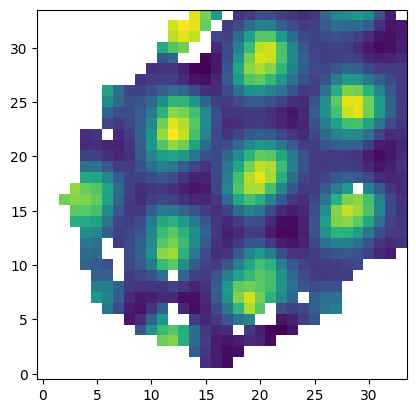

In [28]:
plt.imshow(testSim.spatial_properties.firing_rate_map.T, origin='lower',cmap='viridis')

Changing the animal position will not work here, because the simulation of spike trains from grid cells \
would adjust to the new animal positions \
The best is to stitch the spike trains together

# Stitch a neuron

In [29]:
# Generate a neuron with spike train and animal position:

In [30]:
from spikeA.Neuron import Neuron

def plotReanchoredGridMap(animalPoseObject, inputSpikeTrain, inputInterval=None, show=False):

    testNeuron = Neuron(name="test1")

    testNeuron.set_spike_train(st=inputSpikeTrain)

    testNeuron.set_spatial_properties(
        animal_pose=animalPoseObject
    )  # lap will be changed if the pose object gets changed
    testNeuron.remove_nan_from_ap()

    if inputInterval is not None:
        testNeuron.set_intervals(inputInterval)
    else:
        itv = testNeuron.inter
        testNeuron.set_intervals(itv)

    testNeuron.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, 
                                                     smoothing=True,xy_range = np.array([[-50,-50],[50,50]]))
    # print(testNeuron.spatial_properties.spike_position())
    if show:
        fig, ax = plt.subplots()
        sns.scatterplot(
            x=testNeuron.spatial_properties.spike_position()[:, 0],
            y=testNeuron.spatial_properties.spike_position()[:, 1],
            color="red",
            alpha=1,
            s=5,
        )
        ax.set_aspect("equal")
        ax.set_xlim(-45, 45)
        ax.set_ylim(-45, 45)
        testNeuron.spike_train.instantaneous_firing_rate(bin_size_sec=0.02, sigma=2)

        
        fig, ax = plt.subplots()
        plotMap(
            ax,
            testNeuron.spatial_properties.firing_rate_map,
            title="{0:.2f} Hz".format(
                np.nanmax(testNeuron.spatial_properties.firing_rate_map)
            ),
        )

    return testNeuron

In [31]:
ses, sSes = prepare_ses_sSes(testSession)

interName = 'circ80_1'
sSes.ap.set_intervals(ses.intervalDict[interName])

In [32]:
print(sSes.ap.pose.shape)

(90665, 8)


In [33]:
testSim = Simulated_grid_cell(name=f"test_389", 
                                   offset=paramsNeeded['grid_param_model_flexible']["offset"],
                                   orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                   period=paramsNeeded['grid_param_model_flexible']["period"], 
                                   peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

In [34]:
print(sSes.ap.pose.shape)

(88361, 8)


In [35]:
spikeTrain = testSim.spike_train.st

In [36]:
plotReanchoredGridMap(sSes.ap,spikeTrain)

In [37]:
# I need a function to stitch spike trains together based on the animal position input. 

ses, sSes = prepare_ses_sSes(testSession)

interName = 'all_dark'
# Assuming sSes.ap.pose_ori is a NumPy array with shape (590592, 8)
pose_ori = sSes.ap.pose_ori.copy()

leverX,leverY,leverOri = getLeverPosition(ses)
mouseX = sSes.ap.pose_ori[:,1]-leverX
mouseY = sSes.ap.pose_ori[:,2]-leverY
D = np.sqrt(mouseX**2+mouseY**2)

leverCol = np.column_stack((leverX,leverY,D))  # Alternatively, new_columns = np.array([a, b]).T

pose_ori_new = np.hstack((pose_ori, leverCol))


sSes.ap.pose_ori = pose_ori_new


# Retrieve the interval array from the dictionary
interval = ses.intervalDict[interName]  # Shape: (14, 2)
sSes.ap.set_intervals(interval)


selected_intervals = interval[:]

# Step 3: Create a mask for positions within the selected intervals
stHolder = []
poseHolder = []
timeCounter = 0

offset_ori = paramsNeeded['grid_param_model_flexible']["offset"]
for i, (start, end) in enumerate(selected_intervals):
    #print(i)
    
    if i > 25:
        offset_plot = offset_ori+13
    else:
        offset_plot = offset_ori
    
    sSes.ap.set_intervals(np.array([start,end]))
    #print(sSes.ap.pose.shape)
        
    testSim = Simulated_grid_cell(name=f"test_389", 
                                    offset=offset_plot,
                                    orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                    period=paramsNeeded['grid_param_model_flexible']["period"], 
                                    peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)
    
    
    

    position = sSes.ap.pose
    
    poseDf = pd.DataFrame(position,columns = ['time','x','y','a','b','c','d','e','leverX','leverY','DistanceToLever'])
    maxTime = poseDf.iloc[:,0].max()
    
    # print(maxTime)
    # print('start:',start)
    # print('End',end)
    # print(start+maxTime)
    
    position[:,0] = position[:,0] + timeCounter
    
    
    st = testSim.spike_train.st + timeCounter
    
    # Update the counter
    timeCounter = position[-1][0]
    stHolder.append(st)
    poseHolder.append(position)


    sSes.ap.unset_intervals()
    sSes.ap.pose_ori = pose_ori_new
        


In [38]:
stitchedSt = np.concatenate(stHolder)
stitchedPose = np.concatenate(poseHolder)

In [39]:
stitchedPose[:,0].max()

806.4999999977299

In [40]:
sSes.ap.pose_ori = stitchedPose

In [41]:
sSes.ap.pose = stitchedPose

In [42]:
outN = plotReanchoredGridMap(sSes.ap,stitchedSt)

# Get a function to move the grid map

In [43]:
offset_ori = paramsNeeded['grid_param_model_flexible']["offset"]

In [44]:
offset_ori + [0,1]

array([-37.23478317,  -0.41423368])

In [45]:
ses, sSes = prepare_ses_sSes(testSession)

interName = 'circ80_1'
sSes.ap.set_intervals(ses.intervalDict[interName])
animalPose = sSes.ap.pose_ori

In [46]:
test_grid_period = np.median(paramsNeeded['grid_param_model_flexible']["period"])

In [47]:
test_grid_period

24.056034

In [48]:
def transform_lever_pose_to_grid_offset(leverPosition,grid_period):
    '''
    Function to transform a leverPosition to the grid offset in-order to reanchor the grid map
    
    '''

In [49]:
leverPostionTest = [0,0]

In [50]:
testSim = Simulated_grid_cell(name=f"test_389", 
                                   offset=offset_ori+leverPostionTest,
                                   orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                   period=paramsNeeded['grid_param_model_flexible']["period"], 
                                   peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

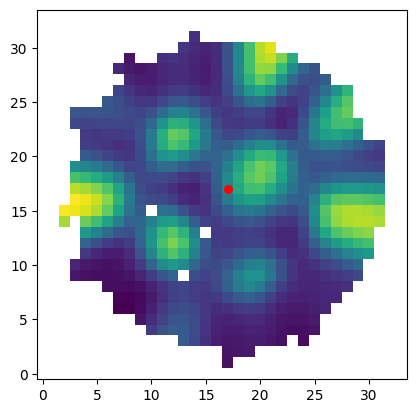

In [51]:
xy_range=np.array([[-50,-50],[50,50]])
def prep_spatial_map(testGc):
    testGc.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)

def test_lever_position_and_fr_map(ax,testGC,leverPose):
    ax.imshow(testGC.spatial_properties.firing_rate_map.T, origin='lower',cmap='viridis')
    
    # Transform lever pose since the position are in the 34 by 34 square
    transLeverPose = np.array(leverPose)/3
    ax.scatter(transLeverPose[0]+17,transLeverPose[1]+17,s=30,c='red')
    
fig, ax =plt.subplots()
prep_spatial_map(testSim)
test_lever_position_and_fr_map(ax,testSim,leverPostionTest)

# Move grid map by lever position

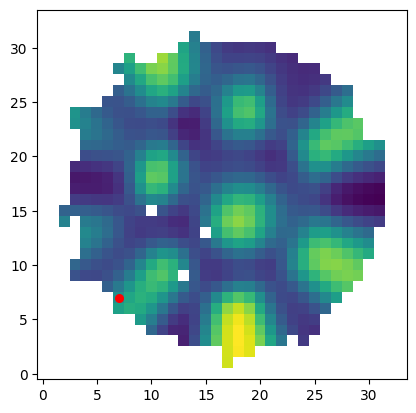

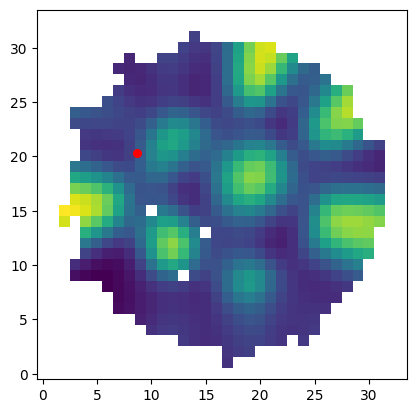

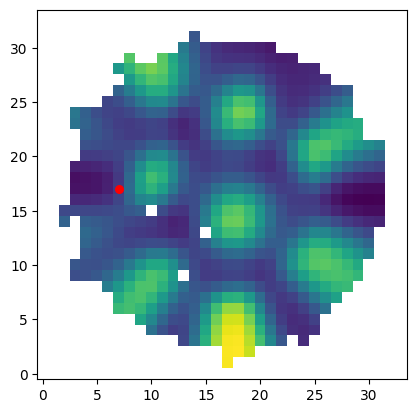

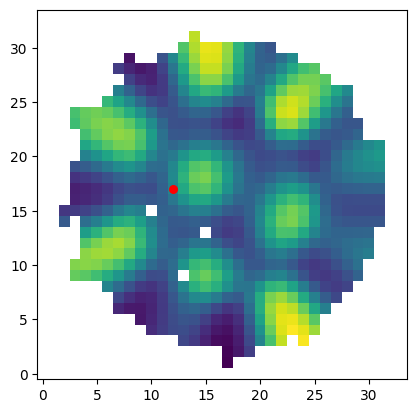

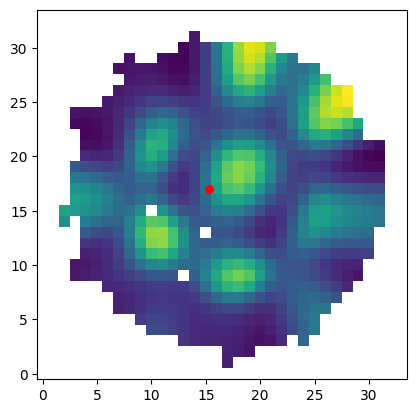

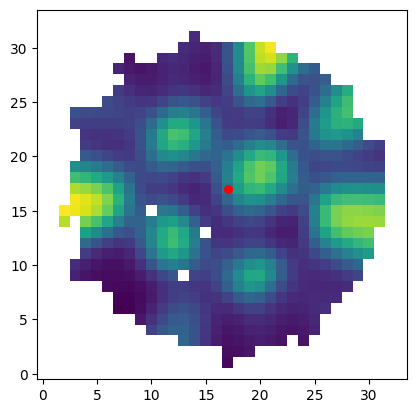

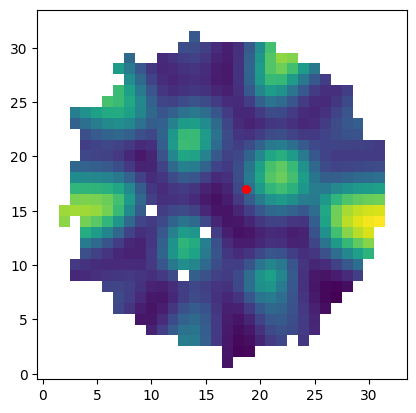

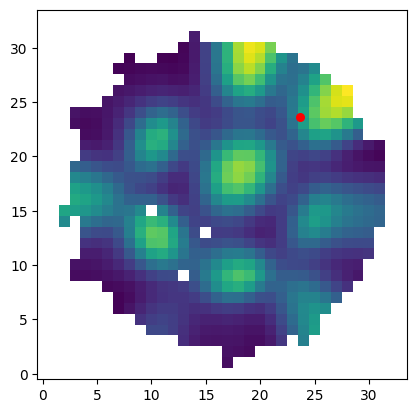

In [52]:
leverPostionTest = [[-30,-30],[-25,10],[-30,0],[-15,0],[-5,0],[0,0],[5,0],[20,20]]

for leverPos in leverPostionTest:
    leverPosTestGc = Simulated_grid_cell(name=f"test_389", 
                                   offset=offset_ori+leverPos,
                                   orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                   period=paramsNeeded['grid_param_model_flexible']["period"], 
                                   peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)
    
    prep_spatial_map(leverPosTestGc)
    
    fig, ax =plt.subplots()
    test_lever_position_and_fr_map(ax,leverPosTestGc,leverPos)

# Transform to lever reference frame

In [53]:
# I need a function to stitch spike trains together based on the animal position input. 

ses, sSes = prepare_ses_sSes(testSession)

interName = 'all_dark'

leverX,leverY,leverOri = getLeverPosition(ses)
mouseX = sSes.ap.pose_ori[:,1]-leverX
mouseY = sSes.ap.pose_ori[:,2]-leverY
D = np.sqrt(mouseX**2+mouseY**2)
leverCol = np.column_stack((leverX,leverY,D))  



pose_ori = sSes.ap.pose_ori.copy()
pose_ori_new = np.hstack((pose_ori, leverCol))

sSes.ap.pose_ori = pose_ori_new


# Retrieve the interval array from the dictionary
selected_intervals = ses.intervalDict[interName]  # Shape: (14, 2)
sSes.ap.set_intervals(selected_intervals)


# Step 3: Create a mask for positions within the selected intervals
stHolder = []
poseHolder = []
leverPoseHolder = []
timeCounter = 0

offset_ori = paramsNeeded['grid_param_model_flexible']["offset"]
for i, (start, end) in enumerate(selected_intervals):

    
    sSes.ap.set_intervals(np.array([start,end]))
        
    _ = Simulated_grid_cell(name=f"test_389", 
                                    offset=offset_ori,
                                    orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                    period=paramsNeeded['grid_param_model_flexible']["period"], 
                                    peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

    position = sSes.ap.pose
    
    poseDf = pd.DataFrame(position,columns = ['time','x','y','a','b','c','d','e','leverX','leverY','DistanceToLever'])
    
    # Find the first index where 'DistanceToLever' is less than 10
    first_idx = poseDf[poseDf['DistanceToLever'] < 10].index[0]
    
    # Find the index of the smallest distance
    
    #first_idx = poseDf['DistanceToLever'].idxmin()

    # Slice the DataFrame up to and including the first occurrence, then reset the index
    dataframeA = poseDf.loc[:first_idx].reset_index(drop=True)

    # Get the maximum value of the first column
    splitByTime = dataframeA.iloc[:, 0].max()
    
    medianTimeFromStartToEnd = (end - start)/2
    

    
    middleTime = start + splitByTime
    
    # Get lever position for this trial
    lx = poseDf.leverX.median()
    ly = poseDf.leverY.median()
    leverPoseHolder.append([lx,ly])
    
    sSes.ap.unset_intervals()
    sSes.ap.pose_ori = pose_ori_new
    
    for num,intervalSplit in enumerate([np.array([start,middleTime]),np.array([middleTime,end])]):
        #print(intervalSplit)
        
        sSes.ap.set_intervals(intervalSplit)
        
        if num == 1:
            offset_plot = offset_ori+[lx,ly]
        else:
            offset_plot = offset_ori
       
        try:
            testSim = Simulated_grid_cell(name=f"test_389", 
                                        offset=offset_plot,
                                        orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                        period=paramsNeeded['grid_param_model_flexible']["period"], 
                                        peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)
            
            split_p = sSes.ap.pose
            
            split_p[:,0] = split_p[:,0] + timeCounter
            st = testSim.spike_train.st + timeCounter
            
            # Update the counter
            timeCounter = split_p[-1][0]
            stHolder.append(st)
            poseHolder.append(split_p)
        except:
            print('Error with num,interval:',num, intervalSplit)
            pass
        
        
        sSes.ap.unset_intervals()
        sSes.ap.pose_ori = pose_ori_new



Error with num,interval: 0 [3127.24 3128.84]
Error with num,interval: 0 [6667.92 6669.08]
Error with num,interval: 0 [7282.3  7283.74]
Error with num,interval: 0 [7411.3 7412.4]
Error with num,interval: 0 [7475.08 7475.8 ]


In [54]:
stitchedSt = np.concatenate(stHolder)
stitchedPose = np.concatenate(poseHolder)

In [55]:
stitchedPose.shape

(40030, 11)

In [56]:
stitchedPose.shape

(40030, 11)

In [57]:
sSes.ap.pose = stitchedPose

In [58]:
outN = plotReanchoredGridMap(sSes.ap,stitchedSt)

In [59]:
maxDistance = 18

def plot_anchoring_to_lever_gc(animalPoseObject,inputSpikeTrain,inputInterval = None,show=False):
    testNeuron = Neuron(name="test1")

    testNeuron.set_spike_train(st=inputSpikeTrain)

    testNeuron.set_spatial_properties(
        animal_pose=animalPoseObject
    )  # lap will be changed if the pose object gets changed
    testNeuron.remove_nan_from_ap()

    if inputInterval is not None:
        testNeuron.set_intervals(inputInterval)
    else:
        itv = testNeuron.inter
        testNeuron.set_intervals(itv)

    testNeuron.spatial_properties.firing_rate_map_2d(cm_per_bin =1, smoothing_sigma_cm = 2,smoothing=True,xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]]))
    # print(testNeuron.spatial_properties.spike_position())
    if show:
        fig, ax = plt.subplots()
        sns.scatterplot(
            x=testNeuron.spatial_properties.spike_position()[:, 0],
            y=testNeuron.spatial_properties.spike_position()[:, 1],
            color="red",
            alpha=1,
            s=5,
        )
        ax.set_aspect("equal")
        ax.set_xlim(-45, 45)
        ax.set_ylim(-45, 45)
        testNeuron.spike_train.instantaneous_firing_rate(bin_size_sec=0.02, sigma=2)

        
        fig, ax = plt.subplots()
        plotMap(
            ax,
            testNeuron.spatial_properties.firing_rate_map,
            title="{0:.2f} Hz".format(
                np.nanmax(testNeuron.spatial_properties.firing_rate_map)
            ),
        )
        
    return testNeuron


In [60]:
outN = plotReanchoredGridMap(sSes.ap,stitchedSt)

In [61]:
leverGc = plot_anchoring_to_lever_gc(sSes.ap,stitchedSt)

In [62]:
# Change reference frame by chaninging the stitched position

In [63]:
stitchedPoseDf = pd.DataFrame(stitchedPose,columns = ['time','x','y','a','b','c','d','e','leverX','leverY','DistanceToLever'])

In [64]:
stitchedPoseDf

,time,x,y,a,b,c,d,e,leverX,leverY,DistanceToLever
0,0.02,3.151393,-43.469678,NaN,1.450409,NaN,NaN,1.654329e+09,22.473707,16.992318,63.474442
1,0.04,2.646672,-43.371469,NaN,1.444582,NaN,NaN,1.654329e+09,22.471750,16.993693,63.537285
2,0.06,2.401259,-43.263069,NaN,1.419912,NaN,NaN,1.654329e+09,22.469696,16.995151,63.512166
3,0.08,2.379202,-43.160346,NaN,1.387747,NaN,NaN,1.654329e+09,22.467550,16.996687,63.422476
4,0.10,2.313679,-43.092489,NaN,1.378802,NaN,NaN,1.654329e+09,22.465316,16.998300,63.379739
...,...,...,...,...,...,...,...,...,...,...,...
40025,800.52,-3.370708,-42.632261,NaN,-1.580198,NaN,NaN,1.654336e+09,17.144694,6.192960,52.960210
40026,800.54,-3.336197,-42.689195,NaN,-1.571178,NaN,NaN,1.654336e+09,17.144465,6.193209,52.999499
40027,800.56,-3.339824,-42.753000,NaN,-1.572495,NaN,NaN,1.654336e+09,17.144253,6.193468,53.059911
40028,800.58,-3.396156,-42.825813,NaN,-1.583367,NaN,NaN,1.654336e+09,17.144059,6.193740,53.149008


In [65]:
stitchedPoseDf['x'] = stitchedPoseDf['x'] - stitchedPoseDf['leverX']
stitchedPoseDf['y'] = stitchedPoseDf['y'] - stitchedPoseDf['leverY']

In [66]:
stitchedPoseDf

,time,x,y,a,b,c,d,e,leverX,leverY,DistanceToLever
0,0.02,-19.322314,-60.461996,NaN,1.450409,NaN,NaN,1.654329e+09,22.473707,16.992318,63.474442
1,0.04,-19.825078,-60.365162,NaN,1.444582,NaN,NaN,1.654329e+09,22.471750,16.993693,63.537285
2,0.06,-20.068437,-60.258220,NaN,1.419912,NaN,NaN,1.654329e+09,22.469696,16.995151,63.512166
3,0.08,-20.088349,-60.157034,NaN,1.387747,NaN,NaN,1.654329e+09,22.467550,16.996687,63.422476
4,0.10,-20.151637,-60.090789,NaN,1.378802,NaN,NaN,1.654329e+09,22.465316,16.998300,63.379739
...,...,...,...,...,...,...,...,...,...,...,...
40025,800.52,-20.515401,-48.825220,NaN,-1.580198,NaN,NaN,1.654336e+09,17.144694,6.192960,52.960210
40026,800.54,-20.480662,-48.882404,NaN,-1.571178,NaN,NaN,1.654336e+09,17.144465,6.193209,52.999499
40027,800.56,-20.484077,-48.946468,NaN,-1.572495,NaN,NaN,1.654336e+09,17.144253,6.193468,53.059911
40028,800.58,-20.540215,-49.019553,NaN,-1.583367,NaN,NaN,1.654336e+09,17.144059,6.193740,53.149008


In [67]:
stitchedPoseDf.loc[stitchedPoseDf['DistanceToLever'] > 18, ['y']] = np.nan

In [68]:
stitchedPoseDf

,time,x,y,a,b,c,d,e,leverX,leverY,DistanceToLever
0,0.02,-19.322314,NaN,NaN,1.450409,NaN,NaN,1.654329e+09,22.473707,16.992318,63.474442
1,0.04,-19.825078,NaN,NaN,1.444582,NaN,NaN,1.654329e+09,22.471750,16.993693,63.537285
2,0.06,-20.068437,NaN,NaN,1.419912,NaN,NaN,1.654329e+09,22.469696,16.995151,63.512166
3,0.08,-20.088349,NaN,NaN,1.387747,NaN,NaN,1.654329e+09,22.467550,16.996687,63.422476
4,0.10,-20.151637,NaN,NaN,1.378802,NaN,NaN,1.654329e+09,22.465316,16.998300,63.379739
...,...,...,...,...,...,...,...,...,...,...,...
40025,800.52,-20.515401,NaN,NaN,-1.580198,NaN,NaN,1.654336e+09,17.144694,6.192960,52.960210
40026,800.54,-20.480662,NaN,NaN,-1.571178,NaN,NaN,1.654336e+09,17.144465,6.193209,52.999499
40027,800.56,-20.484077,NaN,NaN,-1.572495,NaN,NaN,1.654336e+09,17.144253,6.193468,53.059911
40028,800.58,-20.540215,NaN,NaN,-1.583367,NaN,NaN,1.654336e+09,17.144059,6.193740,53.149008


In [69]:
leverCenteredAp = stitchedPoseDf.to_numpy()

In [70]:
ses, sSes = prepare_ses_sSes(testSession)

In [71]:
stitchedSt = np.concatenate(stHolder)

In [72]:
stitchedSt

array([4.962000e-01, 5.774000e-01, 6.395000e-01, ..., 7.990509e+02,
       7.991178e+02, 7.993377e+02])

In [73]:
sSes.ap.pose = leverCenteredAp

In [74]:
outN = plotReanchoredGridMap(sSes.ap,stitchedSt)

In [75]:
outN.spike_train.st

array([4.962000e-01, 5.774000e-01, 6.395000e-01, ..., 7.990509e+02,
       7.991178e+02, 7.993377e+02])

In [76]:
leverGc = plot_anchoring_to_lever_gc(sSes.ap,stitchedSt)

# Create a function from this

In [77]:

# The idea is to get for each example neuron, a simulated neuron
# And what it looks like in the lever reference frame and room reference frame
def load_parameters_from_session(cell_name):
    
    inputSession, cellId = cell_name.split('_')
    
    # load grid cell parameters
    ses, sSes = prepare_ses_sSes(inputSession)

    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
        
    for p in params:
        if p['name'] == cellId:
            neededParams = p
            
            return neededParams

def generate_reanchoring_simulated_grid_cells(cell_name,interName = 'all_dark',with_reanchoring=True):
    
    inputSession, cellId = cell_name.split('_')
    
    # I need a function to stitch spike trains together based on the animal position input. 
    ses, sSes = prepare_ses_sSes(inputSession)
    paramsNeeded = load_parameters_from_session(cell_name)

    leverX,leverY,leverOri = getLeverPosition(ses)
    mouseX = sSes.ap.pose_ori[:,1]-leverX
    mouseY = sSes.ap.pose_ori[:,2]-leverY
    D = np.sqrt(mouseX**2+mouseY**2)
    leverCol = np.column_stack((leverX,leverY,D))  

    pose_ori = sSes.ap.pose_ori.copy()
    pose_ori_new = np.hstack((pose_ori, leverCol))

    sSes.ap.pose_ori = pose_ori_new


    # Retrieve the interval array from the dictionary
    selected_intervals = ses.intervalDict[interName]  # Shape: (14, 2)
    sSes.ap.set_intervals(selected_intervals)


    # Step 3: Create a mask for positions within the selected intervals
    stHolder = []
    poseHolder = []
    leverPoseHolder = []
    timeCounter = 0

    offset_ori = paramsNeeded['grid_param_model_flexible']["offset"]
    for i, (start, end) in enumerate(selected_intervals):

        
        sSes.ap.set_intervals(np.array([start,end]))
            
        _ = Simulated_grid_cell(name=f"test_389", 
                                        offset=offset_ori,
                                        orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                        period=paramsNeeded['grid_param_model_flexible']["period"], 
                                        peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

        position = sSes.ap.pose
        
        poseDf = pd.DataFrame(position,columns = ['time','x','y','a','b','c','d','e','leverX','leverY','DistanceToLever'])
        
        # Find the first index where 'DistanceToLever' is less than 10
        first_idx = poseDf[poseDf['DistanceToLever'] < 10].index[0]

        # Slice the DataFrame up to and including the first occurrence, then reset the index
        dataframeA = poseDf.loc[:first_idx].reset_index(drop=True)

        # Get the maximum value of the first column
        splitByTime = dataframeA.iloc[:, 0].max() #Split by the first time arriving at the lever
        medianTimeFromStartToEnd = (end - start)/2 #Split by the middle
        
        #print(splitByTime,medianTimeFromStartToEnd)
        
        middleTime = start + splitByTime
        
        # Get lever position for this trial
        lx = poseDf.leverX.median()
        ly = poseDf.leverY.median()
        leverPoseHolder.append([lx,ly])
        
        sSes.ap.unset_intervals()
        sSes.ap.pose_ori = pose_ori_new
        
        for num,intervalSplit in enumerate([np.array([start,middleTime]),np.array([middleTime,end])]):
            #print(intervalSplit)
            
            sSes.ap.set_intervals(intervalSplit)
            
            if with_reanchoring:
            
                if num == 1:
                    offset_plot = offset_ori+[lx,ly]
                else:
                    offset_plot = offset_ori
            else:
                if num == 1:
                    offset_plot = offset_ori#+[lx,ly]
                else:
                    offset_plot = offset_ori
        
            try:
                testSim = Simulated_grid_cell(name=f"test_389", 
                                            offset=offset_plot,
                                            orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                            period=paramsNeeded['grid_param_model_flexible']["period"], 
                                            peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)
                
                split_p = sSes.ap.pose
                
                split_p[:,0] = split_p[:,0] + timeCounter
                st = testSim.spike_train.st + timeCounter
                
                # Update the counter
                timeCounter = split_p[-1][0]
                stHolder.append(st)
                poseHolder.append(split_p)
            except:
                print('Error with num,interval:',num, intervalSplit)
                pass
            
            
            sSes.ap.unset_intervals()
            sSes.ap.pose_ori = pose_ori_new
            
    stitchedSt = np.concatenate(stHolder)
    stitchedPose = np.concatenate(poseHolder)
    
    return stitchedPose, stitchedSt

def generate_reanchoring_simulated_grid_cells_reanchoring_per_trial(cell_name,interName = 'all_dark',with_reanchoring=True):
    
    inputSession, cellId = cell_name.split('_')
    
    # I need a function to stitch spike trains together based on the animal position input. 
    ses, sSes = prepare_ses_sSes(inputSession)
    paramsNeeded = load_parameters_from_session(cell_name)

    leverX,leverY,leverOri = getLeverPosition(ses)
    mouseX = sSes.ap.pose_ori[:,1]-leverX
    mouseY = sSes.ap.pose_ori[:,2]-leverY
    D = np.sqrt(mouseX**2+mouseY**2)
    leverCol = np.column_stack((leverX,leverY,D))  

    pose_ori = sSes.ap.pose_ori.copy()
    pose_ori_new = np.hstack((pose_ori, leverCol))

    sSes.ap.pose_ori = pose_ori_new


    # Retrieve the interval array from the dictionary
    selected_intervals = ses.intervalDict[interName]  # Shape: (14, 2)
    sSes.ap.set_intervals(selected_intervals)


    # Step 3: Create a mask for positions within the selected intervals
    stHolder = []
    poseHolder = []
    leverPoseHolder = []
    timeCounter = 0

    offset_ori = paramsNeeded['grid_param_model_flexible']["offset"]
    for i, (start, end) in enumerate(selected_intervals):

        
        sSes.ap.set_intervals(np.array([start,end]))
        
            
        _ = Simulated_grid_cell(name=f"test_389", 
                                        offset=offset_ori,
                                        orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                        period=paramsNeeded['grid_param_model_flexible']["period"], 
                                        peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)

        position = sSes.ap.pose
        
        poseDf = pd.DataFrame(position,columns = ['time','x','y','a','b','c','d','e','leverX','leverY','DistanceToLever'])
        
        
        # Get lever position for this trial
        lx = poseDf.leverX.median()
        ly = poseDf.leverY.median()
        leverPoseHolder.append([lx,ly])
        
        sSes.ap.unset_intervals()
        sSes.ap.pose_ori = pose_ori_new
        
        sSes.ap.set_intervals(np.array([start,end]))
            
        # NOTE offset based on lever position
        
        if with_reanchoring:
            
            offset_plot = offset_ori+[lx,ly]
        else:
            offset_plot = offset_ori
            
        testSim = Simulated_grid_cell(name=f"test_389", 
                                    offset=offset_plot,
                                    orientation=paramsNeeded['grid_param_model_flexible']["orientation"],
                                    period=paramsNeeded['grid_param_model_flexible']["period"], 
                                    peak_rate=paramsNeeded['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)
            
        split_p = sSes.ap.pose
        
        split_p[:,0] = split_p[:,0] + timeCounter
        st = testSim.spike_train.st + timeCounter
        
        # Update the counter
        timeCounter = split_p[-1][0]
        stHolder.append(st)
        poseHolder.append(split_p)
            
        sSes.ap.unset_intervals()
        sSes.ap.pose_ori = pose_ori_new
            
    stitchedSt = np.concatenate(stHolder)
    stitchedPose = np.concatenate(poseHolder)
    
    return stitchedPose, stitchedSt

def process_animal_pose_lever_ref(stichedPosition):
    stitchedPoseDf = pd.DataFrame(stichedPosition,columns = ['time','x','y','a','b','c','d','e',
                                                          'leverX','leverY','DistanceToLever'])
    
    stitchedPoseDf['x'] = stitchedPoseDf['x'] - stitchedPoseDf['leverX']
    stitchedPoseDf['y'] = stitchedPoseDf['y'] - stitchedPoseDf['leverY']
    
    stitchedPoseDf.loc[stitchedPoseDf['DistanceToLever'] > 18, ['y']] = np.nan
    
    lever_ref_position = stitchedPoseDf.to_numpy()
    
    return lever_ref_position

def process_animal_pose_room_ref(stichedPosition):
    stitchedPoseDf = pd.DataFrame(stichedPosition,columns = ['time','x','y','a','b','c','d','e',
                                                          'leverX','leverY','DistanceToLever'])
    
    stitchedPoseDf.loc[stitchedPoseDf['DistanceToLever'] > 18, ['y']] = np.nan
    
    lever_room_position = stitchedPoseDf.to_numpy()
    
    return lever_room_position


def get_room_lever_gc(cell_name,anchor=True):
    stitchedPose, stitchedSt = generate_reanchoring_simulated_grid_cells_reanchoring_per_trial(cell_name,interName='all_dark',with_reanchoring=anchor)
    
    inputSession, cellId = cell_name.split('_')
    
    ses, sSes = prepare_ses_sSes(inputSession)
    lever_ref_pose = process_animal_pose_lever_ref(stitchedPose)
    sSes.ap.pose = lever_ref_pose
    lever_gc = plot_anchoring_to_lever_gc(sSes.ap,stitchedSt)
    
    ses, sSes = prepare_ses_sSes(inputSession)
    room_ref_pose = process_animal_pose_room_ref(stitchedPose)
    sSes.ap.pose = room_ref_pose
    room_gc = plotReanchoredGridMap(sSes.ap,stitchedSt)
    
    return room_gc, lever_gc
    
        

In [78]:
testSession = 'jp3129-04062022-0108'
cellId = '389'
cell_name = 'jp3129-04062022-0108_389'

In [79]:
stitchedPose, stitchedSt = generate_reanchoring_simulated_grid_cells(cell_name,interName='all_dark')    

Error with num,interval: 0 [7282.3  7283.74]
Error with num,interval: 0 [7411.3 7412.4]
Error with num,interval: 0 [7475.08 7475.8 ]


In [80]:
ses, sSes = prepare_ses_sSes(testSession)

lever_ref_pose = process_animal_pose_lever_ref(stitchedPose)

sSes.ap.pose = lever_ref_pose

lever_gc = plot_anchoring_to_lever_gc(sSes.ap,stitchedSt)

In [81]:
ses, sSes = prepare_ses_sSes(testSession)

room_ref_pose = process_animal_pose_room_ref(stitchedPose)

sSes.ap.pose = room_ref_pose

room_gc = plotReanchoredGridMap(sSes.ap,stitchedSt)

In [82]:
def get_simulated_grid_cell_circ80_1(cell_name):
    testSession, cellId = cell_name.split('_')
    ses, sSes = prepare_ses_sSes(testSession)
    
    neededParams = load_parameters_from_session(cell_name)
    
    sSes.ap.set_intervals(ses.intervalDict['circ80_1'])
            
    sim_gc_circ1 = Simulated_grid_cell(name=f"test_389", 
                                    offset=neededParams['grid_param_model_flexible']["offset"],
                                    orientation=neededParams['grid_param_model_flexible']["orientation"],
                                    period=neededParams['grid_param_model_flexible']["period"], 
                                    peak_rate=neededParams['grid_param_model_flexible']["peak_rate"], ap=sSes.ap)
    
    sim_gc_circ1.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, 
                                                     smoothing=True,xy_range = np.array([[-50,-50],[50,50]]))
    
    return sim_gc_circ1

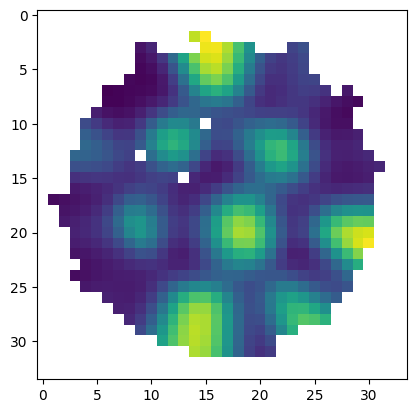

In [83]:
im = get_simulated_grid_cell_circ80_1('jp3129-04062022-0108_389')
inputMap = im.spatial_properties.firing_rate_map
plt.imshow(inputMap)

In [84]:
room_gc, lever_gc = get_room_lever_gc(cell_name,anchor=True)

In [85]:
cell_name = 'jp486-26032023-0108_751'
room_gc, lever_gc = get_room_lever_gc(cell_name,anchor=True)

# Make final figure

In [86]:
GLOBALFONTSIZE = 12

In [87]:
# Simulated with/without grid cell reanchoring
def plot_firing_rate_map(ax,inputMap):
    im = inputMap

    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    ax.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    
    ax.set_title(f'{np.round(np.nanmax(im),2)} Hz',fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

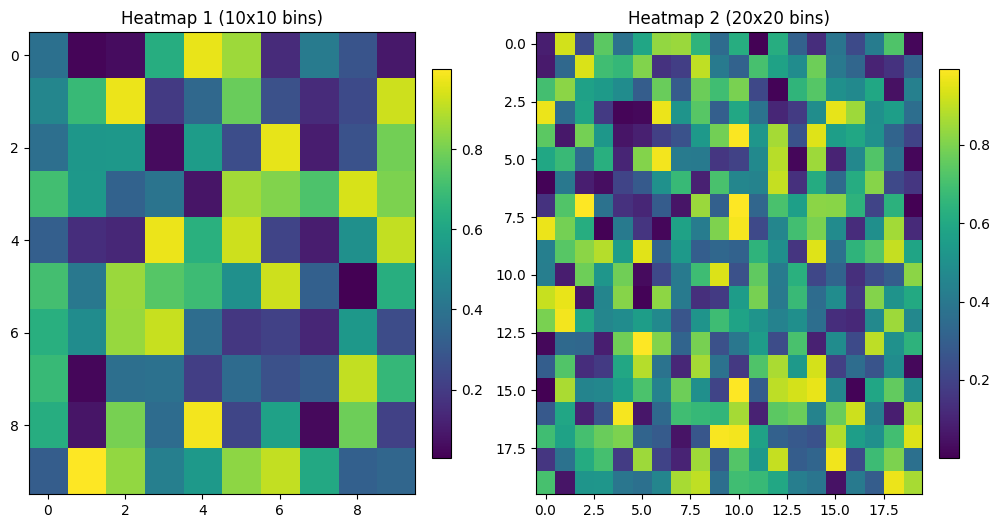

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Sample data for two heatmaps with different bin sizes
# Heatmap 1: 10x10 bins
data1 = np.random.rand(10, 10)
# Heatmap 2: 20x20 bins
data2 = np.random.rand(20, 20)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Heatmap 1
im1 = axes[0].imshow(data1, cmap='viridis', aspect='auto')
axes[0].set_title('Heatmap 1 (10x10 bins)')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot Heatmap 2
im2 = axes[1].imshow(data2, cmap='viridis', aspect='auto')
axes[1].set_title('Heatmap 2 (20x20 bins)')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Function to add a scale bar
def add_scale_bar(ax, scale_length, height=0.02, color='black', label=None, loc='lower right', pad=0.05):
    """
    Adds a scale bar to a matplotlib axis.

    Parameters:
    - ax: The axis to add the scale bar to.
    - scale_length: The length of the scale bar in data units.
    - height: The height of the scale bar as a fraction of the axis height.
    - color: Color of the scale bar.
    - label: Optional label for the scale bar.
    - loc: Location code (e.g., 'lower right').
    - pad: Padding from the specified location.
    """
    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Determine position based on 'loc'
    if loc == 'lower right':
        x_start = xlim[1] - scale_length - (xlim[1] - xlim[0]) * pad
        y_start = ylim[0] + (ylim[1] - ylim[0]) * pad
    elif loc == 'lower left':
        x_start = xlim[0] + (xlim[1] - xlim[0]) * pad
        y_start = ylim[0] + (ylim[1] - ylim[0]) * pad
    elif loc == 'upper right':
        x_start = xlim[1] - scale_length - (xlim[1] - xlim[0]) * pad
        y_start = ylim[1] - (ylim[1] - ylim[0]) * pad - height * (ylim[1] - ylim[0])
    elif loc == 'upper left':
        x_start = xlim[0] + (xlim[1] - xlim[0]) * pad
        y_start = ylim[1] - (ylim[1] - ylim[0]) * pad - height * (ylim[1] - ylim[0])
    else:
        raise ValueError("Unsupported location. Use 'lower right', 'lower left', 'upper right', or 'upper left'.")

    # Add Rectangle patch as scale bar
    rect = Rectangle((x_start, y_start), scale_length, height * (ylim[1] - ylim[0]),
                     linewidth=0, edgecolor=None, facecolor=color, transform=ax.transData, zorder=10)
    ax.add_patch(rect)

    # Add label if provided
    if label:
        ax.text(x_start + scale_length / 2, y_start - (ylim[1] - ylim[0]) * 0.02,
                label, ha='center', va='top', color=color, transform=ax.transData,fontsize=GLOBALFONTSIZE-1)


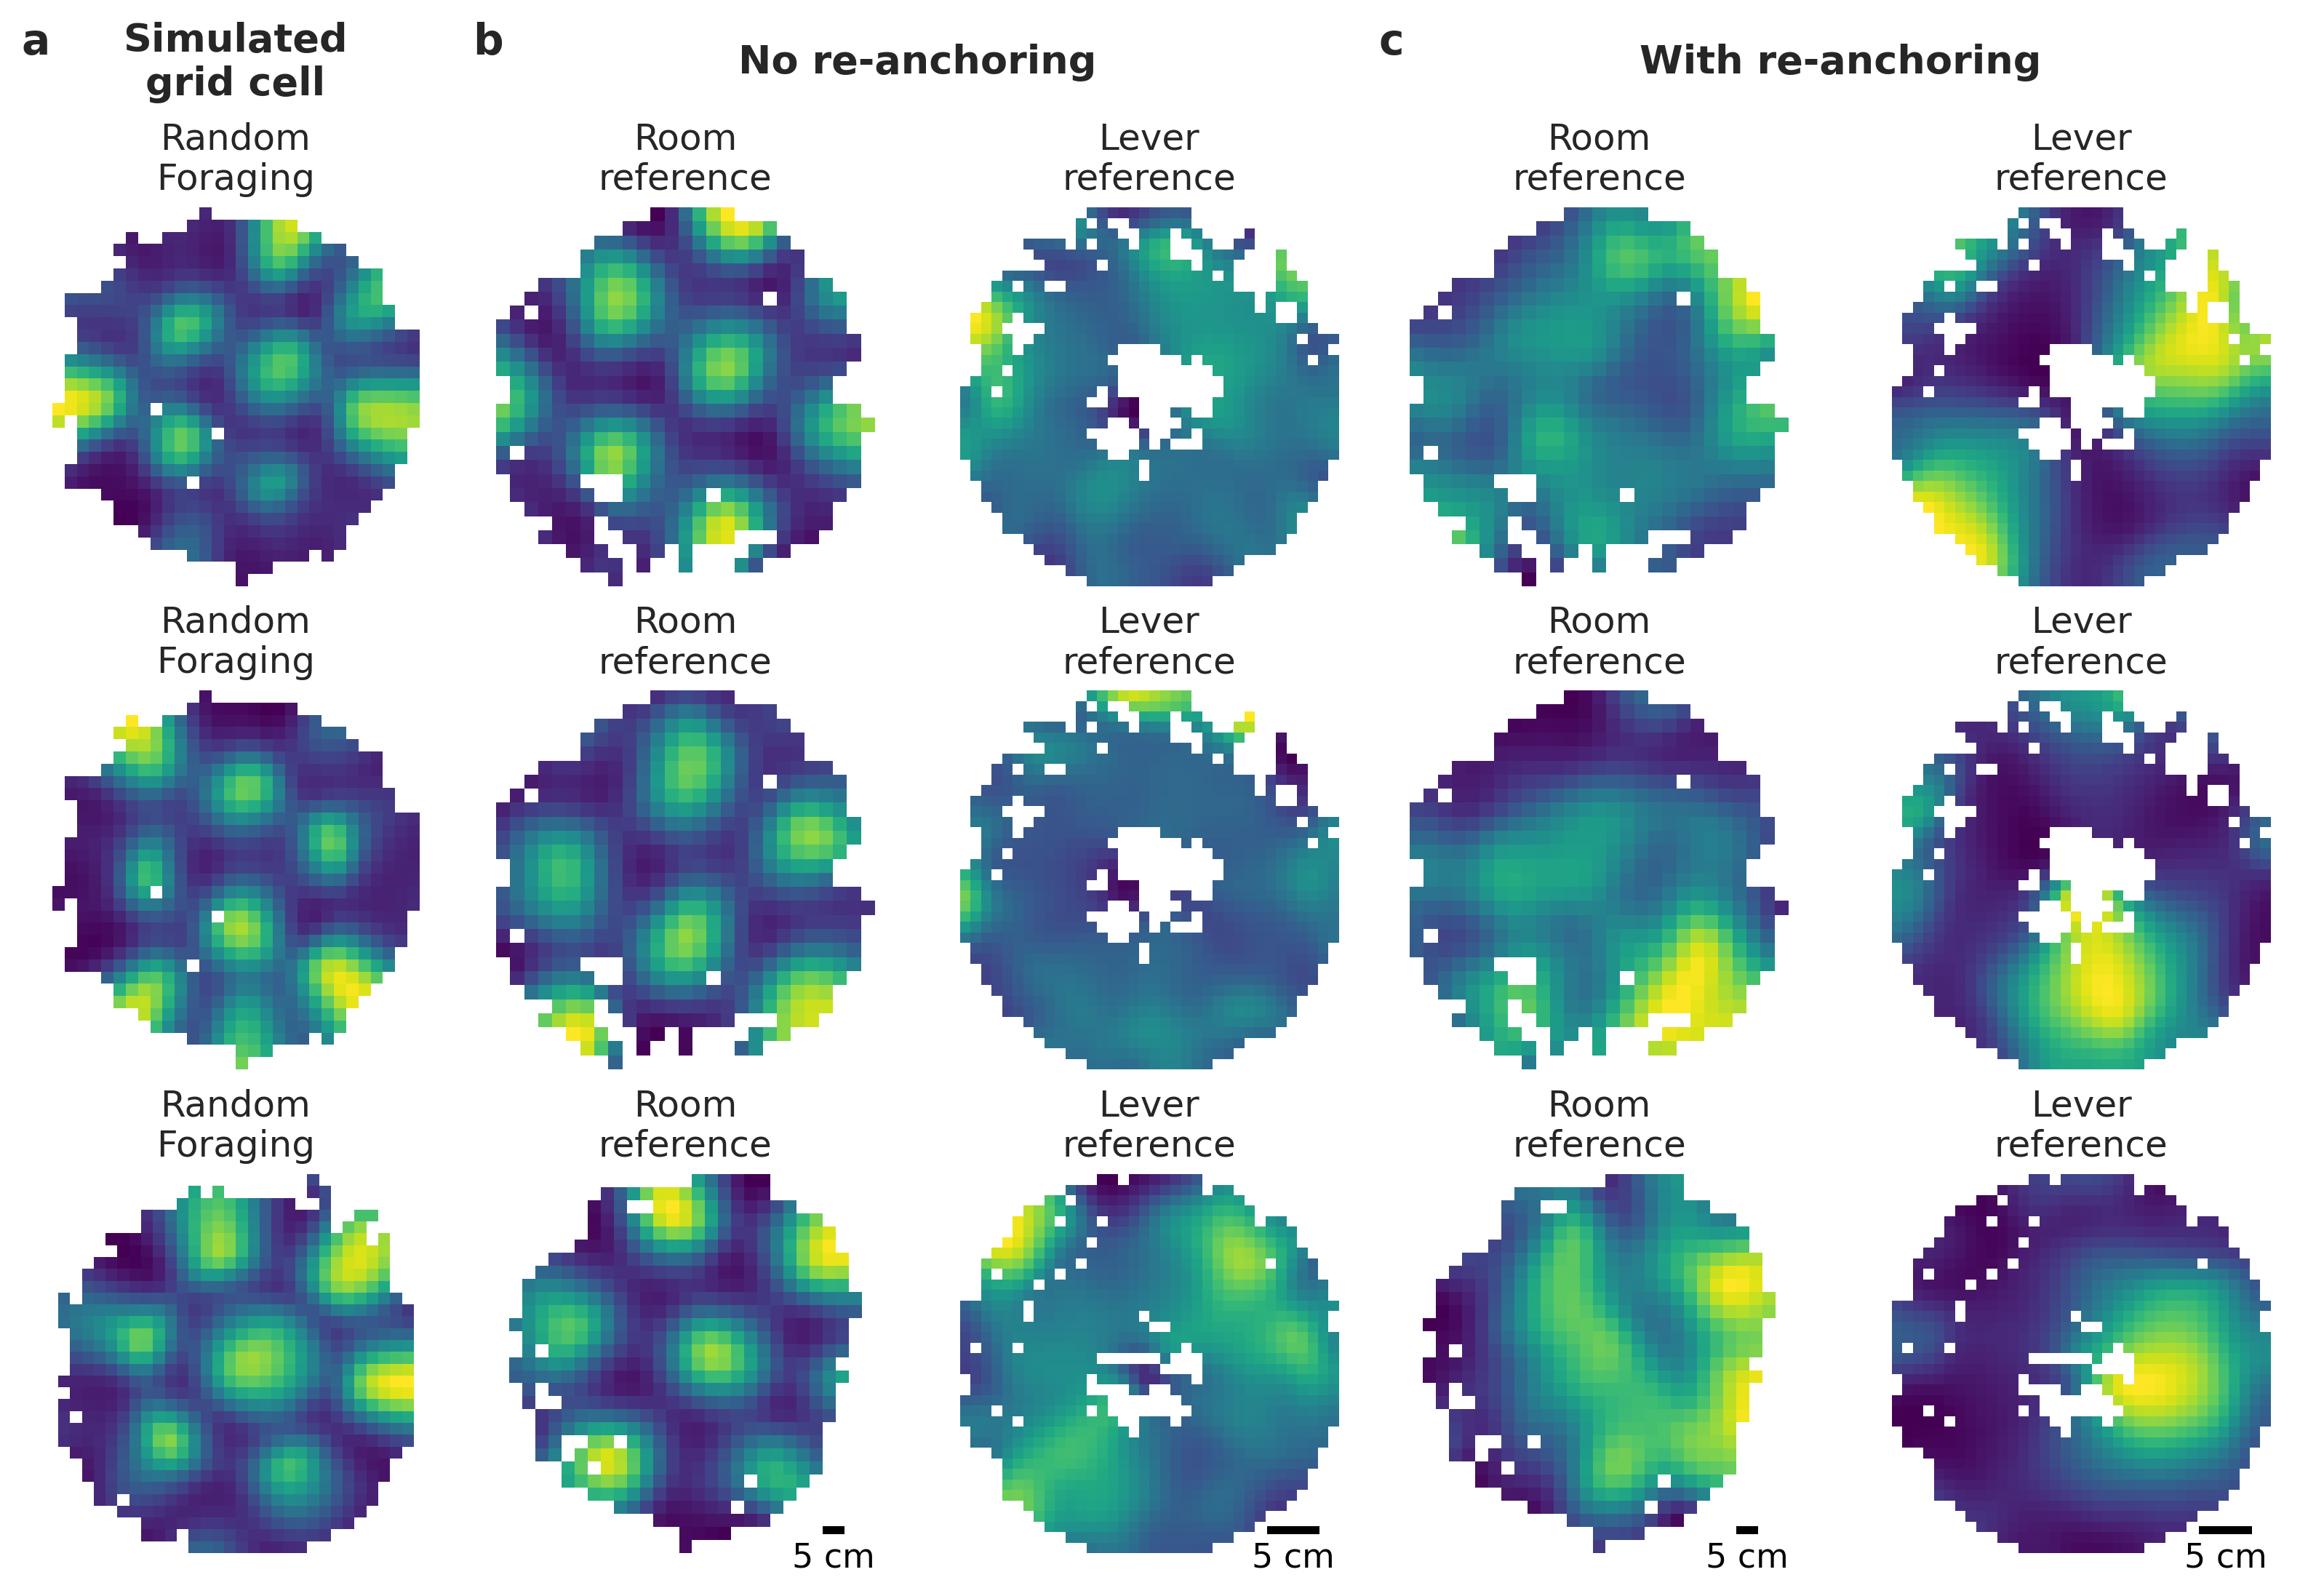

In [90]:
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.image import imread

nrows = 4
ncols = 7
colSize = 1.5
rowSize = 1.8
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE + 2,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)

fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,height_ratios=[0.1,1,1,1],width_ratios=[1,0.01,1,1,0.01,1,1])

# NOTE Scale bar
room_scale = 5/3
lever_scale = 5

# NOTE Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.1,'Simulated\ngrid cell',fontsize=GLOBALFONTSIZE+1,ha='center',va='center',transform=ax0.transAxes,fontweight='bold')
ax0.axis('off')

ax0 = fig.add_subplot(gs[0,2:4])
ax0.text(0.5,0.1,'No re-anchoring',fontsize=GLOBALFONTSIZE+1,ha='center',va='center',transform=ax0.transAxes,fontweight='bold')
ax0.axis('off')

ax0 = fig.add_subplot(gs[0,5:7])
ax0.text(0.5,0.1,'With re-anchoring',fontsize=GLOBALFONTSIZE+1,ha='center',va='center',transform=ax0.transAxes,fontweight='bold')
ax0.axis('off')



# NOTE First example
cell1 = 'jp3129-04062022-0108_389'

im = get_simulated_grid_cell_circ80_1(cell1)
circ80_map = im.spatial_properties.firing_rate_map

ax0 = fig.add_subplot(gs[1,0])
plot_firing_rate_map(ax0,circ80_map)
ax0.set_title('Random\nForaging',fontsize=GLOBALFONTSIZE)


room_gc, lever_gc = get_room_lever_gc(cell1,anchor=False)

ax0 = fig.add_subplot(gs[1,2])
plot_firing_rate_map(ax0,room_gc.spatial_properties.firing_rate_map)
ax0.set_title('Room\nreference',fontsize=GLOBALFONTSIZE)


ax0 = fig.add_subplot(gs[1,3])
plot_firing_rate_map(ax0,lever_gc.spatial_properties.firing_rate_map)
ax0.set_title('Lever\nreference',fontsize=GLOBALFONTSIZE)


room_gc, lever_gc = get_room_lever_gc(cell1,anchor=True)

ax0 = fig.add_subplot(gs[1,5])
plot_firing_rate_map(ax0,room_gc.spatial_properties.firing_rate_map)
ax0.set_title('Room\nreference',fontsize=GLOBALFONTSIZE)


ax0 = fig.add_subplot(gs[1,6])
plot_firing_rate_map(ax0,lever_gc.spatial_properties.firing_rate_map)
ax0.set_title('Lever\nreference',fontsize=GLOBALFONTSIZE)



# NOTE Second example
cell2 = 'jp3129-04062022-0108_340'

im = get_simulated_grid_cell_circ80_1(cell2)
circ80_map = im.spatial_properties.firing_rate_map

ax0 = fig.add_subplot(gs[2,0])
plot_firing_rate_map(ax0,circ80_map)
ax0.set_title('Random\nForaging',fontsize=GLOBALFONTSIZE)


room_gc, lever_gc = get_room_lever_gc(cell2,anchor=False)

ax0 = fig.add_subplot(gs[2,2])
plot_firing_rate_map(ax0,room_gc.spatial_properties.firing_rate_map)
ax0.set_title('Room\nreference',fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs[2,3])
plot_firing_rate_map(ax0,lever_gc.spatial_properties.firing_rate_map)
ax0.set_title('Lever\nreference',fontsize=GLOBALFONTSIZE)

room_gc, lever_gc = get_room_lever_gc(cell2,anchor=True)

ax0 = fig.add_subplot(gs[2,5])
plot_firing_rate_map(ax0,room_gc.spatial_properties.firing_rate_map)
ax0.set_title('Room\nreference',fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs[2,6])
plot_firing_rate_map(ax0,lever_gc.spatial_properties.firing_rate_map)
ax0.set_title('Lever\nreference',fontsize=GLOBALFONTSIZE)

# NOTE Third example
cell3 = 'jp3269-29112022-0108_25'

im = get_simulated_grid_cell_circ80_1(cell3)
circ80_map = im.spatial_properties.firing_rate_map

ax0 = fig.add_subplot(gs[3,0])
plot_firing_rate_map(ax0,circ80_map)
ax0.set_title('Random\nForaging',fontsize=GLOBALFONTSIZE)


room_gc, lever_gc = get_room_lever_gc(cell3,anchor=False)

ax0 = fig.add_subplot(gs[3,2])
plot_firing_rate_map(ax0,room_gc.spatial_properties.firing_rate_map)
ax0.set_title('Room\nreference',fontsize=GLOBALFONTSIZE)
add_scale_bar(ax0, scale_length=room_scale, label='5 cm', loc='lower right')

ax0 = fig.add_subplot(gs[3,3])
plot_firing_rate_map(ax0,lever_gc.spatial_properties.firing_rate_map)
ax0.set_title('Lever\nreference',fontsize=GLOBALFONTSIZE)
add_scale_bar(ax0, scale_length=lever_scale, label='5 cm', loc='lower right')


room_gc, lever_gc = get_room_lever_gc(cell3,anchor=True)

ax0 = fig.add_subplot(gs[3,5])
plot_firing_rate_map(ax0,room_gc.spatial_properties.firing_rate_map)
ax0.set_title('Room\nreference',fontsize=GLOBALFONTSIZE)
add_scale_bar(ax0, scale_length=room_scale, label='5 cm', loc='lower right')


ax0 = fig.add_subplot(gs[3,6])
plot_firing_rate_map(ax0,lever_gc.spatial_properties.firing_rate_map)
ax0.set_title('Lever\nreference',fontsize=GLOBALFONTSIZE)
add_scale_bar(ax0, scale_length=lever_scale, label='5 cm', loc='lower right')


# NOTE Add figure legends
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0.2,1,'b',fw='900')
add_text(ax0,0.6,1,'c',fw='900')

ax0.axis('off')
###

plt.savefig('../../Output/Ext_Figure9.jpg',bbox_inches='tight',dpi=300)